# Libraries

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
!pip install opencv_python==4.5.1.48 \
             matplotlib==3.1.3

In [3]:
import numpy as np
import os
from time import time
import cv2

import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.utils import np_utils


from keras.models import Sequential, Input, Model
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation, LeakyReLU, Add, Multiply
from keras.regularizers import l2
from keras.layers.core import Lambda


import keras.backend as K
from keras.callbacks import LearningRateScheduler

#from keras.utils import multi_gpu_model  
from keras.optimizers import Adam, SGD

import tensorflow as tf

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.95
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

## GPU: no usado

In [6]:
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], 
#                                         cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

# Data generator: download and data augmentation

In [7]:
class DataGenerator(Sequence):
    """Data Generator inherited from keras.utils.Sequence
    Args: 
        directory: the path of data set, and each sub-folder will be assigned to one class
        batch_size: the number of data points in each batch
        shuffle: whether to shuffle the data per epoch
    Note:
        If you want to load file with other data format, please fix the method of "load_data" as you want
    """
    def __init__(self, directory, batch_size=1, shuffle=True, data_augmentation=True):
        # Initialize the params
        self.batch_size = batch_size
        self.directory = directory
        self.shuffle = shuffle
        self.data_aug = data_augmentation
        # Load all the save_path of files, and create a dictionary that save the pair of "data:label"
        self.X_path, self.Y_dict = self.search_data() 
        # Print basic statistics information
        self.print_stats()
        return None
        
    def search_data(self):
        X_path = []
        Y_dict = {}
        # list all kinds of sub-folders
        self.dirs = sorted(os.listdir(self.directory))
        one_hots = np_utils.to_categorical(range(len(self.dirs)))
        for i,folder in enumerate(self.dirs):
            folder_path = os.path.join(self.directory,folder)
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path,file)
                # append the each file path, and keep its label  
                X_path.append(file_path)
                Y_dict[file_path] = one_hots[i]
        return X_path, Y_dict
    
    def print_stats(self):
        # calculate basic information
        self.n_files = len(self.X_path)
        self.n_classes = len(self.dirs)
        self.indexes = np.arange(len(self.X_path))
        np.random.shuffle(self.indexes)
        # Output states
        print("Found {} files belonging to {} classes.".format(self.n_files,self.n_classes))
        for i,label in enumerate(self.dirs):
            print('%10s : '%(label),i)
        return None
    
    def __len__(self):
        # calculate the iterations of each epoch
        steps_per_epoch = np.ceil(len(self.X_path) / float(self.batch_size))
        return int(steps_per_epoch)

    def __getitem__(self, index):
        """Get the data of each batch
        """
        # get the indexs of each batch
        batch_indexs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # using batch_indexs to get path of current batch
        batch_path = [self.X_path[k] for k in batch_indexs]
        # get batch data
        batch_x, batch_y = self.data_generation(batch_path)
        return batch_x, batch_y

    def on_epoch_end(self):
        # shuffle the data at each end of epoch
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, batch_path):
        # load data into memory, you can change the np.load to any method you want
        batch_x = [self.load_data(x) for x in batch_path]
        batch_y = [self.Y_dict[x] for x in batch_path]
        # transfer the data format and take one-hot coding for labels
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        return batch_x, batch_y
      
    def normalize(self, data):
        mean = np.mean(data)
        std = np.std(data)
        return (data-mean) / std
    
    def random_flip(self, video, prob):
        s = np.random.rand()
        if s < prob:
            video = np.flip(m=video, axis=2)
        return video    
    
    def uniform_sampling(self, video, target_frames=64):
        # get total frames of input video and calculate sampling interval 
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        # init empty list for sampled video and 
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])     
        # calculate numer of padded frames and fix it 
        num_pad = target_frames - len(sampled_video)
        if num_pad>0:
            padding = [video[i] for i in range(-num_pad,0)]
            sampled_video += padding     
        # get sampled video
        return np.array(sampled_video, dtype=np.float32)
    
    def dynamic_crop(self, video):
        # extract layer of optical flow from video
        opt_flows = video[...,3]
        # sum of optical flow magnitude of individual frame
        magnitude = np.sum(opt_flows, axis=0)
        # filter slight noise by threshold 
        thresh = np.mean(magnitude)
        magnitude[magnitude<thresh] = 0
        # calculate center of gravity of magnitude map and adding 0.001 to avoid empty value
        x_pdf = np.sum(magnitude, axis=1) + 0.001
        y_pdf = np.sum(magnitude, axis=0) + 0.001
        # normalize PDF of x and y so that the sum of probs = 1
        x_pdf /= np.sum(x_pdf)
        y_pdf /= np.sum(y_pdf)
        # randomly choose some candidates for x and y 
        x_points = np.random.choice(a=np.arange(224), size=10, replace=True, p=x_pdf)
        y_points = np.random.choice(a=np.arange(224), size=10, replace=True, p=y_pdf)
        # get the mean of x and y coordinates for better robustness
        x = int(np.mean(x_points))
        y = int(np.mean(y_points))
        # avoid to beyond boundaries of array
        x = max(56,min(x,167))
        y = max(56,min(y,167))
        # get cropped video 
        return video[:,x-56:x+56,y-56:y+56,:]  
    
    def color_jitter(self,video):
        # range of s-component: 0-1
        # range of v component: 0-255
        s_jitter = np.random.uniform(-0.2,0.2)
        v_jitter = np.random.uniform(-30,30)
        for i in range(len(video)):
            hsv = cv2.cvtColor(video[i], cv2.COLOR_RGB2HSV)
            s = hsv[...,1] + s_jitter
            v = hsv[...,2] + v_jitter
            s[s<0] = 0
            s[s>1] = 1
            v[v<0] = 0
            v[v>255] = 255
            hsv[...,1] = s
            hsv[...,2] = v
            video[i] = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return video
        
    def load_data(self, path):
        data = np.load(path, mmap_mode='r')[...,:3]
        data = np.float32(data)
        # sampling 64 frames uniformly from the entire video
        data = self.uniform_sampling(video=data, target_frames=64)
        # whether to utilize the data augmentation
        if  self.data_aug:
            data = self.color_jitter(data)
            data = self.random_flip(data, prob=0.5)
        # normalize
        data = self.normalize(data)
        return data

# Build the model

In [8]:
inputs = Input(shape=(64,224,224,3))

#####################################################
rgb = inputs
rgb = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

#####################################################
x = MaxPooling3D(pool_size=(8,1,1))(rgb)

#####################################################
x = Conv3D(
    64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)

x = Conv3D(
    64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)

x = Conv3D(
    128, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    128, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,3,3))(x)

#####################################################
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
pred = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=pred)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 224, 224, 3)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 64, 224, 224, 16)  448       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 224, 224, 16)  784       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 112, 112, 16)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 112, 112, 16)  2320      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 64, 112, 112, 16)  784       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 56, 56, 16)    0     

## Callbacks

In [9]:
def scheduler(epoch):
    # Every 10 epochs, the learning rate is reduced to 1/10 of the original
    if epoch % 10 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.5)
    return K.get_value(model.optimizer.lr)

reduce_lr = LearningRateScheduler(scheduler)

#OJO ACA PODEMOS AGREGAR OTROS DE EARLY STOPPING O GUARDAR MODELO

Set the GPUs and make it parallel

In [10]:
#only with cuda
#os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"


#parallel_model = multi_gpu_model(model, gpus=1)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [11]:
#otra forma
# parallel_model = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], 
#                                          cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

In [12]:
# from keras.callbacks import ModelCheckpoint, CSVLogger
# import keras

# class MyCbk(keras.callbacks.Callback):

#     def __init__(self, model):
#          self.model_to_save = model

#     def on_epoch_end(self, epoch, logs=None):
#         self.model_to_save.save('Logs/model_at_epoch_%d.h5' % (epoch+1))

# check_point = MyCbk(model)

In [13]:
#callbacks_list = [check_point, reduce_lr]
callbacks_list = [reduce_lr]

## Model compilling

In [14]:
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

#with strategy.scope():
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
#set parameters
num_epochs  = 50
num_workers = 16
batch_size  = 3

In [16]:
#directory
#os.getcwd()
os.path.exists('C:/Users/61402/Documents/UTS/GitHub/violence_detection/anaconda_scripts/validation')

#OneDrive/UTS03 Assigments 3/RWF-2000

True

In [17]:
#datasets
#dataset = 'RWF2000-opt'
path_train = 'C:/Users/61402/Documents/UTS/GitHub/violence_detection/anaconda_scripts/train'
path_test = 'C:/Users/61402/Documents/UTS/GitHub/violence_detection/anaconda_scripts/validation'

train_generator = DataGenerator(directory=path_train, 
                                batch_size=batch_size, 
                                data_augmentation=True)

val_generator = DataGenerator(directory=path_test,
                              batch_size=batch_size, 
                              data_augmentation=False)


Found 1207 files belonging to 2 classes.
     Fight :  0
  NonFight :  1
Found 393 files belonging to 2 classes.
     Fight :  0
  NonFight :  1


In [18]:
#start training
hist = model.fit_generator(
    generator=train_generator, 
    validation_data=val_generator,
    callbacks=callbacks_list,
    verbose=1, 
    epochs=num_epochs,
   # workers=num_workers,
    max_queue_size=8,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator))

Epoch 1/50
403/403 [==============================] - 394s 948ms/step - loss: 1.9437 - accuracy: 0.4774 - val_loss: 0.6933 - val_accuracy: 0.4987
Epoch 2/50
403/403 [==============================] - 385s 953ms/step - loss: 0.6953 - accuracy: 0.4942 - val_loss: 0.6980 - val_accuracy: 0.5013
Epoch 3/50
403/403 [==============================] - 387s 959ms/step - loss: 0.7004 - accuracy: 0.4884 - val_loss: 0.7080 - val_accuracy: 0.4987
Epoch 4/50
403/403 [==============================] - 397s 985ms/step - loss: 0.6989 - accuracy: 0.4937 - val_loss: 0.6996 - val_accuracy: 0.5013
Epoch 5/50
403/403 [==============================] - 386s 956ms/step - loss: 0.6979 - accuracy: 0.4902 - val_loss: 0.6934 - val_accuracy: 0.5013
Epoch 6/50
403/403 [==============================] - 385s 953ms/step - loss: 0.6954 - accuracy: 0.5259 - val_loss: 0.7036 - val_accuracy: 0.4987
Epoch 7/50
403/403 [==============================] - 385s 955ms/step - loss: 0.7010 - accuracy: 0.4883 - val_loss: 0.6935 -

In [19]:
# conda list

In [20]:
model.save('Logs/model_at_epoch_final.h5')

## Look the results

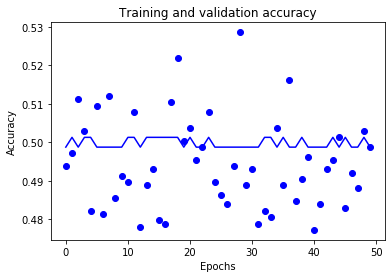

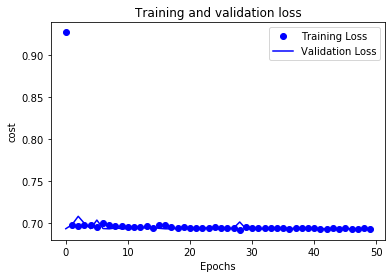

In [21]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.ylabel('cost')
plt.xlabel('Epochs')

plt.show()